In [1]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

import tensorflow as tf
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import numpy as np

2026-02-05 10:17:55.521180: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-05 10:17:55.539345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770286675.558541   78691 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770286675.563897   78691 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770286675.587187   78691 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import sys 
sys.path.append("..")
from RUN_TENSORBOARD import *

# Launch TensorBoard to monitor training
events_folder = "./logs_attention"
main(events_folder)

Selected port: 60955


/home/n/.conda/envs/ai_dev/lib/python3.12/site-packages/tensorboard/default.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2026-02-05 10:17:57.884417: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-05 10:17:57.892337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770286677.901791   78788 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one h

In [3]:
import pickle 

# Load the preprocessed datasets
with open('X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('Y.pkl', 'rb') as f:
    Y = pickle.load(f)

# Perform Stratified Split: Train (80%), Val (10%), Test (10%)
# Determine which samples have at least one trigger word for stratification
y_has_trigger = np.any(Y > 0, axis=(1, 2))

X_train, X_val_test, Y_train, Y_val_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=y_has_trigger
)

# Split the remaining 20% into 50% Val, 50% Test (10% total each)
y_has_trigger_val = np.any(Y_val_test > 0, axis=(1, 2))
X_val, X_test, Y_val, Y_test = train_test_split(
    X_val_test, Y_val_test, test_size=0.5, random_state=42, stratify=y_has_trigger_val
)

print(f"Training set shape: {X_train.shape}, {Y_train.shape}")
print(f"Dev (Val) set shape: {X_val.shape}, {Y_val.shape}")
print(f"Test set shape: {X_test.shape}, {Y_test.shape}")

# Handle Imbalance using Sample Weights
def get_sample_weights(y, weight_factor=10.0):
    """
    Calculate sample weights where positive timesteps get higher weight.
    """
    # Initialize weights with 1.0
    weights = np.ones(y.shape[:2])
    # Apply higher weight to positive classes (1s)
    # y shape is (samples, steps, 1), so squeeze to (samples, steps)
    weights[y.squeeze() == 1] = weight_factor
    return weights

# Calculate dynamic weight factor based on ratio
neg = np.sum(Y_train == 0)
pos = np.sum(Y_train == 1)
total = neg + pos
w1 = (1 / pos) * (total / 2.0)
w0 = (1 / neg) * (total / 2.0)
# We will base our factor relative to w0 being approx 1, so factor ~ w1/w0
weight_factor = w1 / w0
print(f"Calculated class weight factor for positives: {weight_factor:.2f}")

train_sample_weights = get_sample_weights(Y_train, weight_factor)
val_sample_weights = get_sample_weights(Y_val, weight_factor)
del X
del Y
del X_val_test
del Y_val_test

Training set shape: (29914, 431, 256), (29914, 105, 1)
Dev (Val) set shape: (3739, 431, 256), (3739, 105, 1)
Test set shape: (3740, 431, 256), (3740, 105, 1)
Calculated class weight factor for positives: 3.76


In [4]:
class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, d_model, **kwargs):
        super().__init__(**kwargs)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=max_len, output_dim=d_model)
        self.max_len = max_len
        self.d_model = d_model
    
    def call(self, x):
        maxlen = tf.shape(x)[1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'max_len': self.max_len,
            'd_model': self.d_model,
        })
        return config


def build_model(hp):
    """
    Build a transformer model with tunable hyperparameters.
    
    Tunable parameters:
    - conv_filters: Number of filters in Conv1D layer
    - num_transformer_blocks: Number of transformer blocks (1-4)
    - num_heads: Number of attention heads
    - ff_dim: Feed-forward network dimension
    - dropout_rate: Dropout rate
    - learning_rate: Adam optimizer learning rate
    
    Note: kernel_size is fixed at 15 to ensure output timesteps (105) match target Y shape.
    Formula: output_length = (input_length - kernel_size) // stride + 1 = (431 - 15) // 4 + 1 = 105
    """
    input_shape = (431, 256)  # (Tx, n_freq)
    kernel_size = 15  # Fixed to produce exactly 105 output timesteps matching Y
    
    # Hyperparameters to tune
    conv_filters = hp.Int('conv_filters', min_value=64, max_value=256, step=32)
    num_transformer_blocks = hp.Int('num_transformer_blocks', min_value=1, max_value=4)
    num_heads = hp.Int('num_heads', min_value=1, max_value=4)
    ff_dim = hp.Int('ff_dim', min_value=64, max_value=256, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.05)
    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-3, sampling='log')
    
    X_input = Input(shape=input_shape)
    
    # Conv layer (kernel_size=15 with stride=4 produces 105 timesteps)
    X = Conv1D(conv_filters, kernel_size=kernel_size, strides=4)(X_input)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = Dropout(dropout_rate)(X)
    
    # Positional Encoding
    X = PositionEmbedding(max_len=105, d_model=conv_filters)(X)
    
    # Transformer blocks
    for _ in range(num_transformer_blocks):
        # Multi-head self-attention
        key_dim = conv_filters
        attn_out = MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=key_dim,
            dropout=dropout_rate
        )(X, X)
        X = LayerNormalization()(X + attn_out)
        
        # Feed-forward network
        ff = Dense(ff_dim, activation='relu')(X)
        ff = Dropout(dropout_rate)(ff)
        ff = Dense(conv_filters)(ff)
        X = LayerNormalization()(X + ff)
    
    # Output layer
    X = TimeDistributed(Dense(1, activation="sigmoid"))(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    opt = Adam(learning_rate=learning_rate)
    model.compile(
        loss='binary_crossentropy', # Changed to binary_crossentropy to use sample_weight
        optimizer=opt, 
        metrics=["accuracy", Precision(name='precision'), Recall(name='recall')]
    )
    
    return model

In [5]:
Tx = 431  # input timesteps
n_freq = 256  # mel frequency bins
Ty = 105  # output timesteps

hop_length = 256 
n_mels = 256

In [6]:
# Hyperparameter Tuning with Keras Tuner
# Using Bayesian Optimization

tuner = kt.BayesianOptimization(
    build_model,
    objective=[kt.Objective('val_loss', direction='min'),kt.Objective('val_precision', direction='max'),kt.Objective('val_recall', direction='max')],
    max_trials=20,
    executions_per_trial=1,
    directory='keras_tuner_logs',
    project_name='trigger_word_transformer',
    overwrite=False 
)

tuner.search_space_summary()

Reloading Tuner from keras_tuner_logs/trigger_word_transformer/tuner0.json
Search space summary
Default search space size: 6
conv_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
num_transformer_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
num_heads (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
ff_dim (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [7]:
# Run the hyperparameter search with Sample Weights and Validation Set
callbacks_best = [
    tf.keras.callbacks.TensorBoard(
        log_dir=events_folder,
        histogram_freq=1,
        write_graph=True,
        update_freq='batch'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=40,
        restore_best_weights=True
    ),
]

tuner.search(
    X_train, 
    Y_train,
    validation_data=(X_val, Y_val, val_sample_weights),
    batch_size=8,
    epochs=100,
    callbacks=callbacks_best,
    sample_weight=train_sample_weights,
    verbose=1
)

Trial 20 Complete [00h 28m 14s]
multi_objective: -1.5269740968942642

Best multi_objective So Far: -1.6006591469049454
Total elapsed time: 2d 00h 07m 32s


In [8]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"  conv_filters: {best_hps.get('conv_filters')}")
print(f"  num_transformer_blocks: {best_hps.get('num_transformer_blocks')}")
print(f"  num_heads: {best_hps.get('num_heads')}")
print(f"  ff_dim: {best_hps.get('ff_dim')}")
print(f"  dropout_rate: {best_hps.get('dropout_rate'):.2f}")
print(f"  learning_rate: {best_hps.get('learning_rate'):.6f}")

Best Hyperparameters:
  conv_filters: 128
  num_transformer_blocks: 4
  num_heads: 4
  ff_dim: 64
  dropout_rate: 0.10
  learning_rate: 0.000104


In [9]:
# Build the best model and train it fully
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 431, 256)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 105, 128)  │    491,648 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 105, 128)  │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 105, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 105, 128)  │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding… │ (None, 105, 128)  │     13,440 │ dropout_3[0][0]   │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 105, 128)  │    263,808 │ position_embeddi… │
│ (MultiHeadAttentio… │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 105, 128)  │          0 │ position_embeddi… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 105, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 105, 64)   │      8,256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 105, 64)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 105, 128)  │      8,320 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 105, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 105, 128)  │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 105, 128)  │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 105, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 105, 128)  │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 105, 64)   │      8,256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 105, 64)   │          0 │ dense_5[0][0]   

 Total params: 1,629,313 (6.22 MB)

 Trainable params: 1,629,057 (6.21 MB)

 Non-trainable params: 256 (1.00 KB)

In [10]:
callbacks_best = [
    tf.keras.callbacks.TensorBoard(
        log_dir=events_folder,
        histogram_freq=1,
        write_graph=True,
        update_freq='batch'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=40,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        './keras_tuner_logs/best_model_multi_head_attention.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
]

history = best_model.fit(
    X_train, 
    Y_train, 
    batch_size=16, 
    epochs=300, 
    callbacks=callbacks_best, 
    validation_data=(X_val, Y_val, val_sample_weights),
    sample_weight=train_sample_weights
)
# Load the best trained model
best_model.load_weights('./keras_tuner_logs/best_model_multi_head_attention.keras')

Epoch 1/300


2026-02-05 11:05:11.591774: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_408', 468 bytes spill stores, 436 bytes spill loads

2026-02-05 11:05:11.678048: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_408', 552 bytes spill stores, 488 bytes spill loads

2026-02-05 11:05:11.752876: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_415', 4 bytes spill stores, 4 bytes spill loads

2026-02-05 11:05:11.765042: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_408', 600 bytes spill stores, 532 bytes spill loads

2026-02-05 11:05:11.922327: I external/l

   6/1870 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.4755 - loss: 1.3525 - precision: 0.2177 - recall: 0.5151    

2026-02-05 11:05:24.821971: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'fusion_1635', 300 bytes spill stores, 328 bytes spill loads



1864/1870 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7309 - loss: 0.7568 - precision: 0.4311 - recall: 0.7890

2026-02-05 11:05:41.948960: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_415', 8 bytes spill stores, 8 bytes spill loads

2026-02-05 11:05:42.046435: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_415', 8 bytes spill stores, 8 bytes spill loads

2026-02-05 11:05:42.100983: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_408', 468 bytes spill stores, 436 bytes spill loads

2026-02-05 11:05:42.236998: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_415', 240 bytes spill stores, 240 bytes spill loads

2026-02-05 11:05:42.426804: I external/local

1870/1870 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7311 - loss: 0.7564 - precision: 0.4313 - recall: 0.7892

2026-02-05 11:05:57.557559: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_142', 108 bytes spill stores, 108 bytes spill loads

2026-02-05 11:05:57.581875: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_134_0', 192 bytes spill stores, 192 bytes spill loads

2026-02-05 11:05:57.611296: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_142', 32 bytes spill stores, 32 bytes spill loads

2026-02-05 11:05:57.656931: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_142', 408 bytes spill stores, 408 bytes spill loads

2026-02-05 11:05:57.677474: I extern

1870/1870 ━━━━━━━━━━━━━━━━━━━━ 64s 22ms/step - accuracy: 0.7312 - loss: 0.7563 - precision: 0.4313 - recall: 0.7893 - val_accuracy: 0.8149 - val_loss: 0.4938 - val_precision: 0.5353 - val_recall: 0.9518
Epoch 2/300
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8525 - loss: 0.4604 - precision: 0.5995 - recall: 0.9094 - val_accuracy: 0.8678 - val_loss: 0.3863 - val_precision: 0.6244 - val_recall: 0.9428
Epoch 3/300
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8774 - loss: 0.3905 - precision: 0.6469 - recall: 0.9240 - val_accuracy: 0.8664 - val_loss: 0.3697 - val_precision: 0.6189 - val_recall: 0.9611
Epoch 4/300
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8890 - loss: 0.3490 - precision: 0.6679 - recall: 0.9338 - val_accuracy: 0.8814 - val_loss: 0.3494 - val_precision: 0.6529 - val_recall: 0.9393
Epoch 5/300
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8967 - loss: 0.3269 - precision: 0.6848 - recall: 0.9392 - val_accuracy: 0.9133 - val

In [11]:
# Evaluate on the Test set
print("Evaluating on Test set...")
test_loss, test_acc, test_prec, test_recall = best_model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Precision: {test_prec}")
print(f"Test Recall: {test_recall}")

Evaluating on Test set...


2026-02-05 11:37:53.079355: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_142', 108 bytes spill stores, 108 bytes spill loads

2026-02-05 11:37:53.137572: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_141', 56 bytes spill stores, 56 bytes spill loads

2026-02-05 11:37:53.203293: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_141', 240 bytes spill stores, 240 bytes spill loads

2026-02-05 11:37:53.418790: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_134', 372 bytes spill stores, 372 bytes spill loads

2026-02-05 11:37:53.469359: I external

116/117 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9502 - loss: 0.1317 - precision: 0.8306 - recall: 0.9600

2026-02-05 11:37:58.959823: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_142', 408 bytes spill stores, 408 bytes spill loads

2026-02-05 11:37:59.060446: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_142', 32 bytes spill stores, 32 bytes spill loads

2026-02-05 11:37:59.418795: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_142', 108 bytes spill stores, 108 bytes spill loads

2026-02-05 11:37:59.516477: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 24 bytes spill stores, 28 bytes spill loads

2026-02-05 11:37:59.587757: I external/loc

117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.9502 - loss: 0.1318 - precision: 0.8306 - recall: 0.9600
Test Loss: 0.13279388844966888
Test Accuracy: 0.949967086315155
Test Precision: 0.828683614730835
Test Recall: 0.9594918489456177


# Predictions

In [12]:
import matplotlib.pyplot as plt
from pydub import AudioSegment
import matplotlib.pyplot as plt
import librosa
import numpy as np
import IPython


In [13]:

def get_mels_spectogram(file):
    """
    Generate Mel spectrogram from an audio file.
    
    Args:
        file (str): Path to the audio file
        
    Returns:
        tuple: Contains:
            - y_orig (np.ndarray): Original audio time series
            - S_orig (np.ndarray): Mel spectrogram
            - S_dB_orig (np.ndarray): Mel spectrogram in decibels
            - sr (int): Sample rate of the audio file
    """
    y_orig, sr = librosa.load(file)
    S_orig = librosa.feature.melspectrogram(y=y_orig, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_dB_orig = librosa.power_to_db(S_orig, ref=np.max)
    return y_orig, S_orig, S_dB_orig, sr


def match_target_amplitude(sound, target_dBFS):
    """
    Adjust the volume of an audio segment to match a target amplitude level.
    
    Args:
        sound (AudioSegment): Audio segment to adjust
        target_dBFS (float): Target amplitude in decibels relative to full scale
        
    Returns:
        AudioSegment: Audio segment with adjusted volume
    """
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)


def trigger_word_detections(filename, out_filename = "tmp.wav"):
    """
    Detect trigger words in an audio file and visualize the results.
    
    Processes the audio file, generates predictions using the model, and plots
    both the mel spectrogram and the prediction probabilities over time.
    
    Args:
        filename (str): Path to input audio file
        out_filename (str): Path for temporary normalized audio file (default: "tmp.wav")
        
    Returns:
        np.ndarray: Model predictions with shape (1, timesteps, 1) containing
                   probabilities of trigger word detection at each timestep
    """
    fig, ax = plt.subplots(2, 1, figsize=(6, 4))
    
    # Normalize audio amplitude before processing
    audio_clip = AudioSegment.from_wav(filename)
    audio_clip = match_target_amplitude(audio_clip, -20.0)
    
    file_handle = audio_clip.export(out_filename, format="wav")
    y_gen, S_gen, S_dB_gen, sr = get_mels_spectogram(out_filename)

    # Reshape spectrogram for model: (freqs, timesteps) -> (timesteps, freqs)
    x = S_gen.swapaxes(0, 1)
    x = np.expand_dims(x, axis=0)
    print(x.shape)
    predictions = best_model.predict(x)

    # Plot spectrogram
    librosa.display.specshow(S_dB_gen, sr=sr, x_axis='time', y_axis='mel', ax=ax[0], cmap='magma')

    # Plot detection probabilities
    ax[1].plot(predictions[0, :, 0])
    ax[1].set_ylabel('probability')
    plt.show()
    
    return predictions

In [14]:
file = "./Dataset/training_set/train_2.wav"
IPython.display.Audio(file)

(1, 431, 256)


2026-02-05 11:38:06.093607: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 16 bytes spill stores, 16 bytes spill loads

2026-02-05 11:38:06.225488: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 264 bytes spill stores, 264 bytes spill loads

2026-02-05 11:38:06.276789: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 144 bytes spill stores, 144 bytes spill loads

2026-02-05 11:38:06.296498: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 552 bytes spill stores, 488 bytes spill loads

2026-02-05 11:38:06.511841: I external/lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


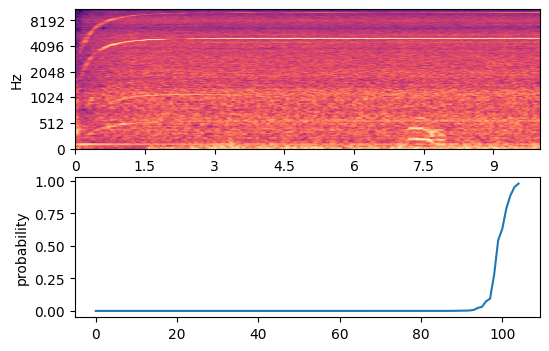

array([[[7.47663307e-06],
        [6.57190503e-06],
        [5.64887068e-06],
        [8.10220808e-06],
        [5.37745336e-06],
        [8.65021229e-06],
        [8.82262157e-06],
        [6.84745055e-06],
        [6.19110597e-06],
        [5.05301023e-06],
        [4.99147018e-06],
        [4.92251820e-06],
        [5.23569088e-06],
        [5.01637533e-06],
        [4.81871666e-06],
        [4.28388375e-06],
        [4.95701579e-06],
        [5.32427066e-06],
        [6.40781445e-06],
        [7.99430200e-06],
        [5.76177354e-06],
        [5.77568608e-06],
        [5.42200723e-06],
        [5.26137819e-06],
        [5.81230415e-06],
        [5.49079732e-06],
        [5.96743621e-06],
        [5.95101210e-06],
        [6.02373302e-06],
        [5.26526310e-06],
        [5.46788397e-06],
        [5.86454235e-06],
        [5.56226951e-06],
        [6.42940995e-06],
        [8.76009381e-06],
        [8.38278083e-06],
        [7.40507676e-06],
        [8.05430500e-06],
        [7.5

In [15]:
predictions  = trigger_word_detections(file)
predictions